# Predicting Customer Churn

Replicating the findings by Denis Batalov at https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/. Denis's initial work was done using the AWS ML service, but I will use sklearn's library for my modeling.

The goal of this project is to predict whether a customer will churn away from a mobile phone operator. 

**Attributes**
* State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
* Account Length: the number of days that this account has been active
* Area Code: the three-digit area code of the corresponding customer’s phone number
* Phone: the remaining seven-digit phone number
* Int’l Plan: whether the customer has an international calling plan: yes/no
* VMail Plan: whether the customer has a voice mail feature: yes/no
* VMail Message: presumably the average number of voice mail messages per month
* Day Mins: the total number of calling minutes used during the day
* Day Calls: the total number of calls placed during the day
* Day Charge: the billed cost of daytime calls
* Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
* Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
* Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
* CustServ Calls: the number of calls placed to Customer Service
* Churn?: whether the customer left the service: true/false

The last attribute, Churn?, is our outcome attribute that we are trying to predcit using binary classification.

## Data Preparation

In [213]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [187]:
# Load churn data
churn = pd.read_csv('data/churn.txt')

# Clean data
churn['Churn?'] = churn['Churn?'].str.replace('.$', '') # Remove '.' from end of True/False values
churn.columns = churn.columns.str.replace(' ', '_') # Replace ' ' with '_'
churn.columns = churn.columns.str.replace("'", "") # Remove "'" special character
churn['Intl_Plan'] = churn.Intl_Plan.map(dict(yes=True, no=False)) # Convert yes/no to Boolean value
churn['VMail_Plan'] = churn.VMail_Plan.map(dict(yes=True, no=False)) # Convert yes/no to Boolean value
churn['Churn?'] = churn['Churn?'] == 'True' # Convert object to Boolean values

churn.dtypes

State              object
Account_Length      int64
Area_Code           int64
Phone              object
Intl_Plan            bool
VMail_Plan           bool
VMail_Message       int64
Day_Mins          float64
Day_Calls           int64
Day_Charge        float64
Eve_Mins          float64
Eve_Calls           int64
Eve_Charge        float64
Night_Mins        float64
Night_Calls         int64
Night_Charge      float64
Intl_Mins         float64
Intl_Calls          int64
Intl_Charge       float64
CustServ_Calls      int64
Churn?               bool
dtype: object

## EDA

In [188]:
# Summary statistics
display(churn.describe())
print('Unique Area Codes:', len(churn.Area_Code.unique()))
print('Unique States:', len(churn.State.unique()))
print('Unique Phone Numbers', len(churn.Phone.unique()))

# Drop ficticious phone numbers
churn.drop(['Area_Code', 'Phone', 'State'], axis=1, inplace=True)

,Account_Length,Area_Code,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Unique Area Codes: 3
Unique States: 51
Unique Phone Numbers 3333


Looking at the summary statistics, we can see that there are only 3 distinct area codes, but 51 unique states (50 states + DC). One possibility is that the phone numbers were randomized or made up to preserve privacy. This explains the discrepency is the phone number data. Thus we'll drop these ficticious values.

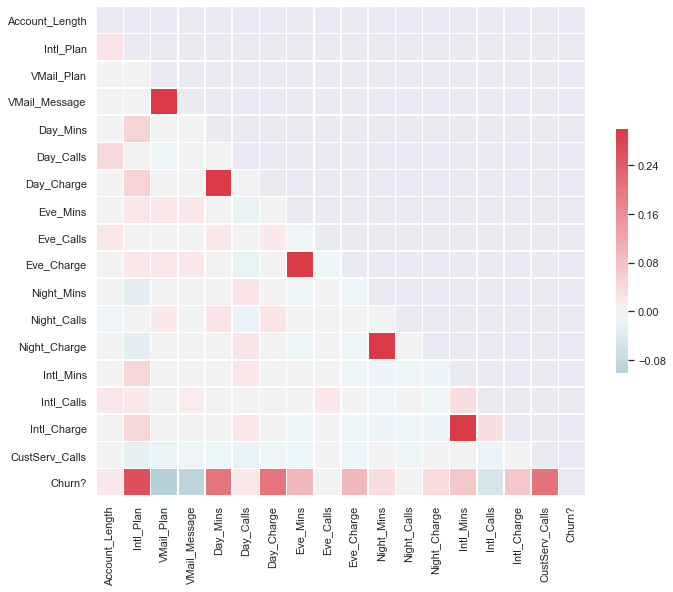

In [189]:
# Compute correlations
corr = churn.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
figure, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

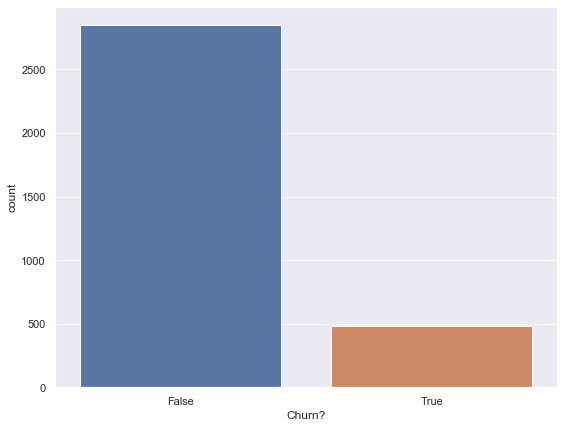

True Customer Churn Percentage: 14.49%


In [238]:
# Set up figure
figure, ax = plt.subplots(figsize=(9,7))

# Draw counts barplot
sns.countplot(x='Churn?', data=churn)

plt.show()

print('True Customer Churn Percentage: {:.2f}%'.format((churn['Churn?'] == 1).sum()/len(churn['Churn?']) * 100))


## Modeling

In [249]:
xtrain, xtest, ytrain, ytest = train_test_split(churn.loc[:, churn.columns != 'Churn?'], churn['Churn?'],
                                                test_size=.25)


In [250]:
model1 = LogisticRegression(C=100000, solver='lbfgs', max_iter=1000).fit(xtrain, ytrain)

In [253]:
preds = model1.predict(xtest)

confusion_matrix(ytest, preds)
# print(model1.score(xtest,ytest))


array([[698,  21],
       [ 90,  25]])

In [257]:
# Tree
tree = DecisionTreeClassifier().fit(xtrain, ytrain)
tree_preds = tree.predict(xtest)

confusion_matrix(ytest, tree_preds)

array([[681,  38],
       [ 36,  79]])

## Assigning Costs

The associated costs with customer churn are going to vary depending on the specific actions that the business takes. For the purposes of this project, I will use the assigned costs Denis uses for his model.
* True Negative: \$0
* False Negative: \$500
* True Positie: \$100
* False Positive: \$100